In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import json
import subprocess
from scipy.misc import imread
%matplotlib inline

from train import build_forward
from utils import train_utils
from utils.annolist import AnnotationLib as al
from utils.stitch_wrapper import stitch_rects
from utils.train_utils import add_rectangles
from utils.rect import Rect
from utils.stitch_wrapper import stitch_rects
from evaluate import add_rectangles
import cv2

In [6]:
hypes_file = './hypes/lstm_rezoom.json'
iteration = 99999
with open(hypes_file, 'r') as f:
    H = json.load(f)
true_json = './data/brainwash/val_boxes.json'
pred_json = './output/%d_val_%s.json' % (iteration, os.path.basename(hypes_file).replace('.json', ''))
true_annos = al.parse(true_json)

INFO:tensorflow:Restoring parameters from ./output/lstm_rezoom_2017_08_10_23.09/save.ckpt-99999
0
100
200
300
400
20.400041 images/sec


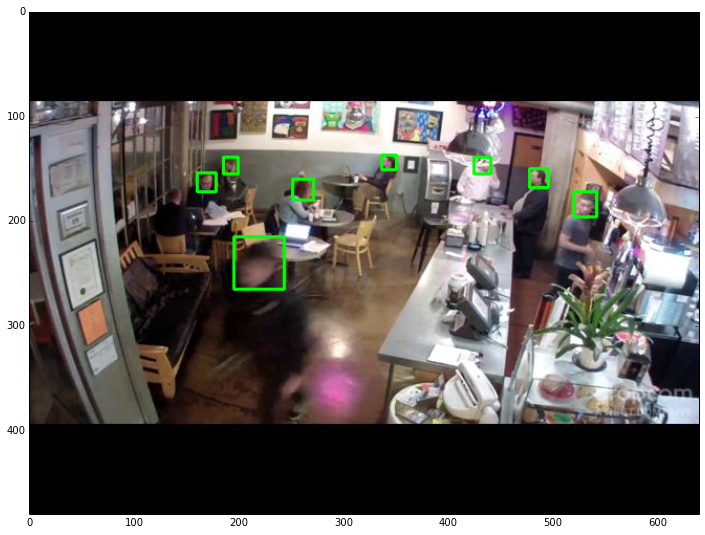

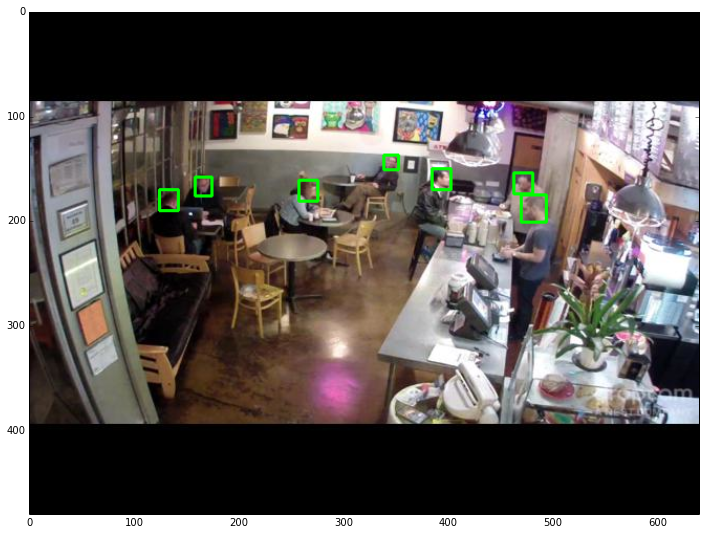

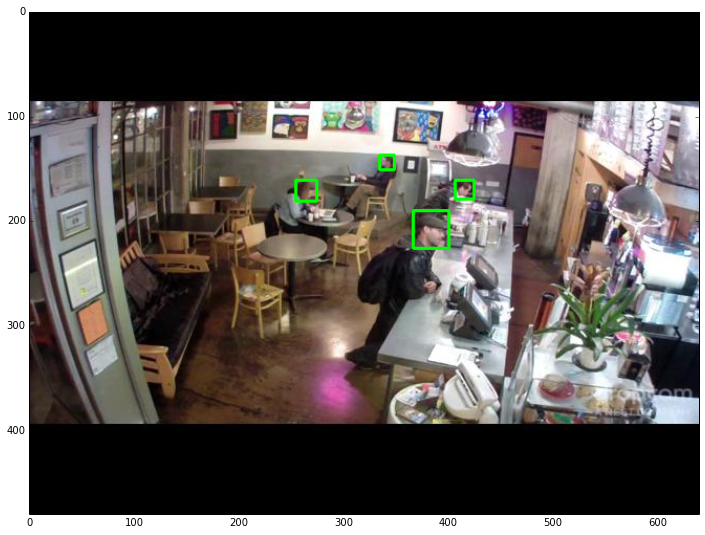

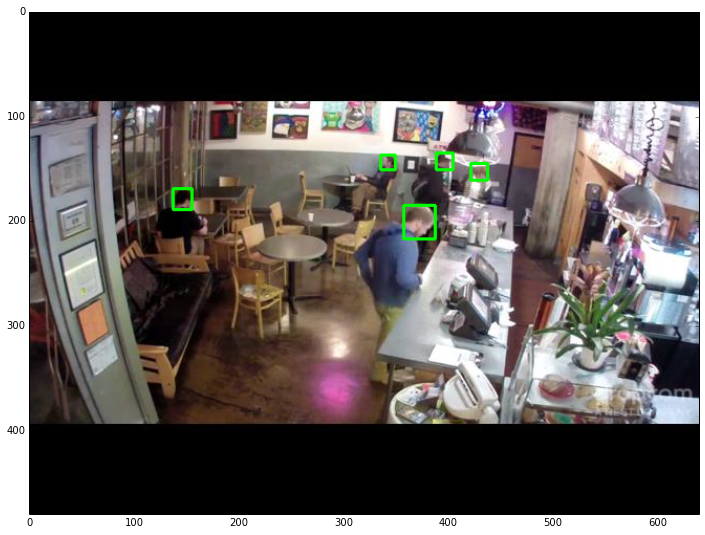

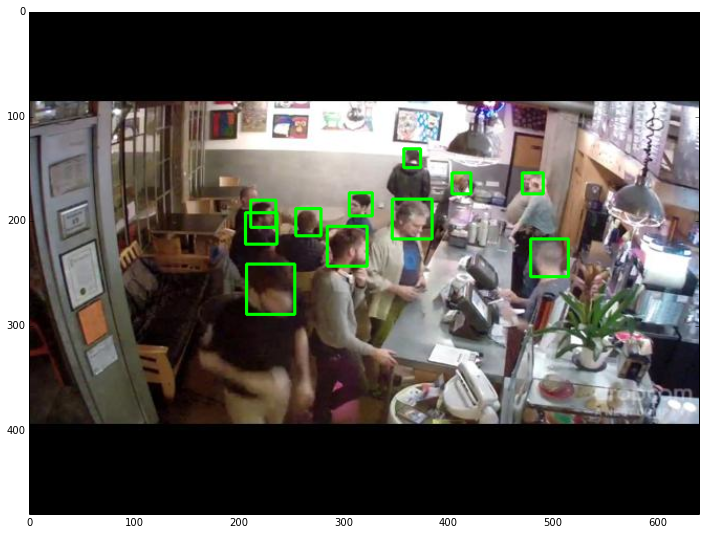

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


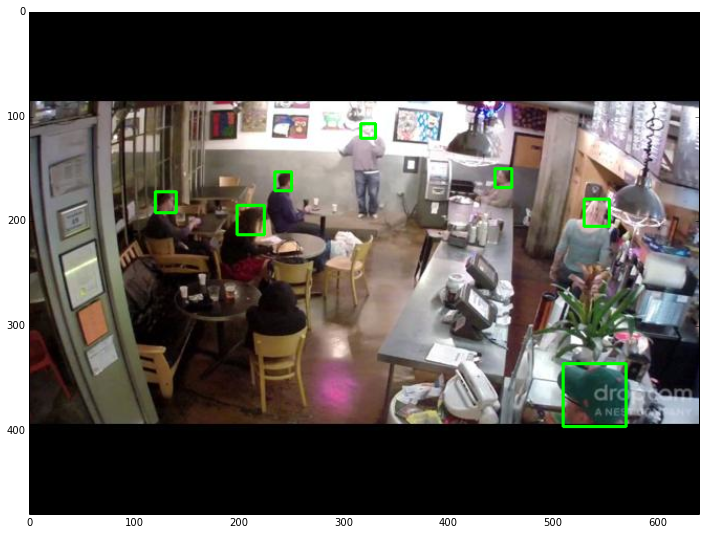

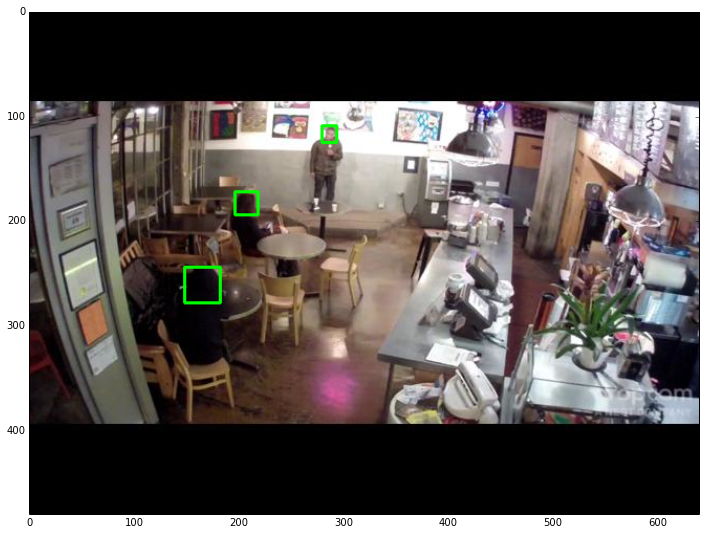

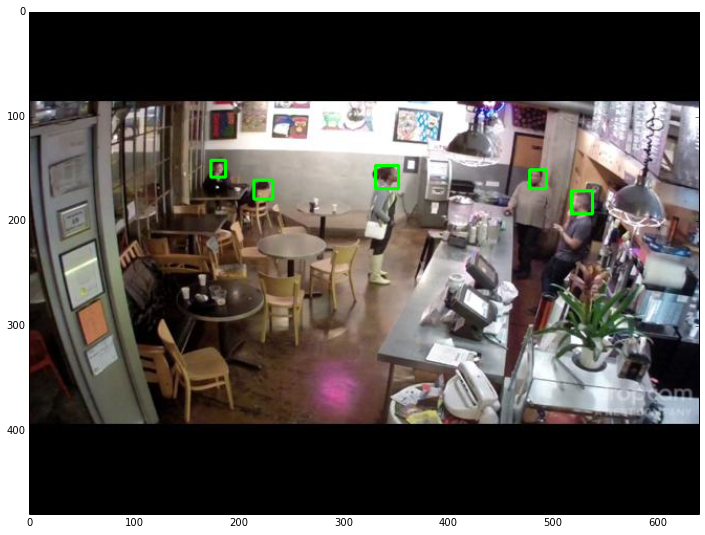

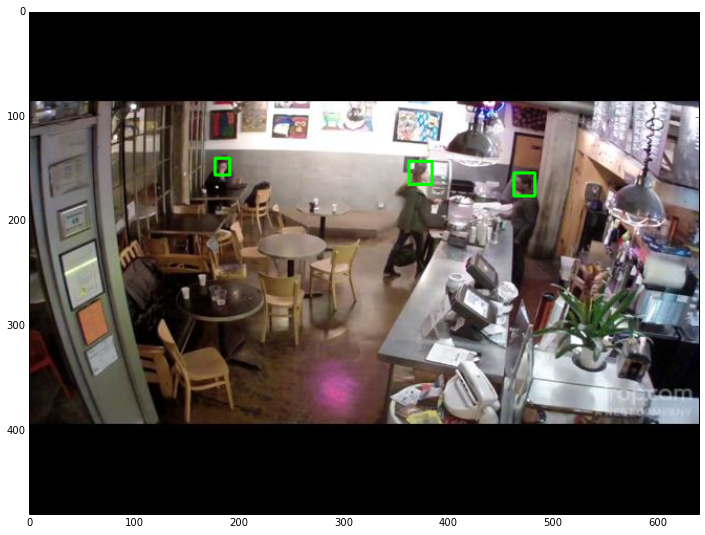

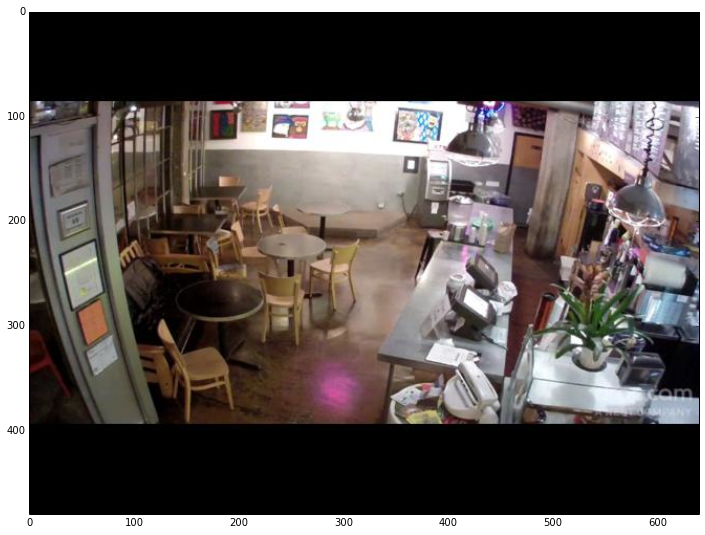

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


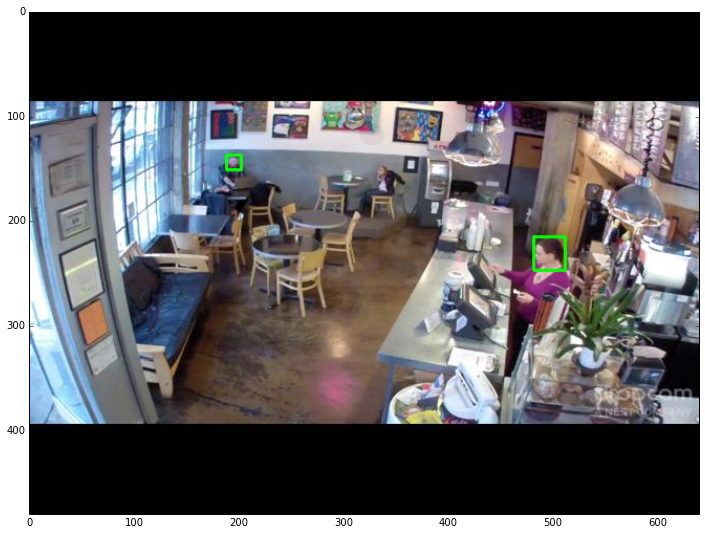

In [8]:
tf.reset_default_graph()
x_in = tf.placeholder(tf.float32, name='x_in', shape=[H['image_height'], H['image_width'], 3])
if H['use_rezoom']:
    pred_boxes, pred_logits, pred_confidences, pred_confs_deltas, pred_boxes_deltas = build_forward(H, tf.expand_dims(x_in, 0), 'test', reuse=None)
    grid_area = H['grid_height'] * H['grid_width']
    pred_confidences = tf.reshape(tf.nn.softmax(tf.reshape(pred_confs_deltas, [grid_area * H['rnn_len'], 2])), [grid_area, H['rnn_len'], 2])
    if H['reregress']:
        pred_boxes = pred_boxes + pred_boxes_deltas
else:
    pred_boxes, pred_logits, pred_confidences = build_forward(H, tf.expand_dims(x_in, 0), 'test', reuse=None)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './output/lstm_rezoom_2017_08_10_23.09/save.ckpt-%d' % iteration)

    annolist = al.AnnoList()
    import time; t = time.time()
    for i in range(0, 500):
        true_anno = true_annos[i]
        img = imread('./data/brainwash/%s' % true_anno.imageName)
        feed = {x_in: img}
        (np_pred_boxes, np_pred_confidences) = sess.run([pred_boxes, pred_confidences], feed_dict=feed)
        pred_anno = al.Annotation()
        pred_anno.imageName = true_anno.imageName
        new_img, rects = add_rectangles(H, [img], np_pred_confidences, np_pred_boxes,
                                        use_stitching=True, rnn_len=H['rnn_len'], min_conf=0.7,
                                        show_suppressed=False)
    
        pred_anno.rects = rects
        annolist.append(pred_anno)

        if i % 10 == 0 and i < 200:
            pass
            fig = plt.figure(figsize=(12, 12))
            plt.imshow(new_img)
        if i % 100 == 0:
            print(i)
    avg_time = (time.time() - t) / (i + 1)
    print('%f images/sec' % (1. / avg_time))

saving:  ./output/99999_val_lstm_rezoom.json
$ ./utils/annolist/doRPC.py --minOverlap 0.500000 ./data/brainwash/val_boxes.json ./output/99999_val_lstm_rezoom.json
Minimum width: 0 height: 0
Asorting too large/ too small detections
minWidth: 0
minHeight: 0
maxWidth:  inf
maxHeight:  inf
#Annotations: 3318
Setting up graphs ...
missingFrames:  0
Number of detections on annotated frames:  6743
Sorting scores ...
Gradually decrease score ...
saving:
/home/zhluo/work/LSTM/rnn/TensorBox/output/rpc-99999_val_lstm_rezoom_overlap0.5.txt

$ ./utils/annolist/plotSimple.py /home/zhluo/work/LSTM/rnn/TensorBox/output/rpc-99999_val_lstm_rezoom_overlap0.5.txt --output output/results.png


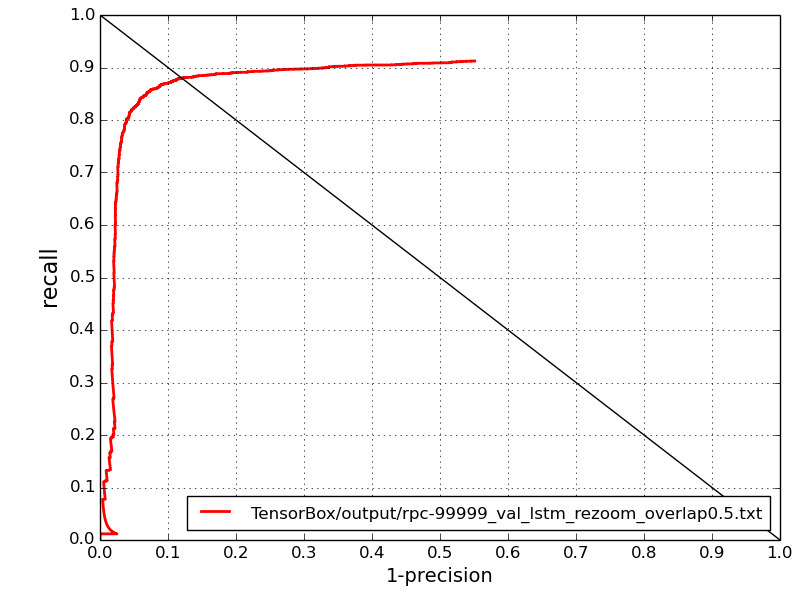

In [9]:
annolist.save(pred_json)
iou_threshold = 0.5
rpc_cmd = './utils/annolist/doRPC.py --minOverlap %f %s %s' % (iou_threshold, true_json, pred_json)
print('$ %s' % rpc_cmd)
rpc_output = subprocess.check_output(rpc_cmd, shell=True)
print(rpc_output)
txt_file = [line for line in rpc_output.split('\n') if line.strip()][-1]
output_png = 'output/results.png'
plot_cmd = './utils/annolist/plotSimple.py %s --output %s' % (txt_file, output_png)
print('$ %s' % plot_cmd)
plot_output = subprocess.check_output(plot_cmd, shell=True)
from IPython.display import Image
Image(filename=output_png) 